In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, datasets

In [3]:
EPOCHS = 50
BATCH_SIZE = 128

In [4]:
trainset, testset = datasets.mnist.load_data()

In [5]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

In [6]:
class DeepConvolutionGAN(models.Model):
    
    def __init__(self):
        super(DeepConvolutionGAN, self).__init__()
        
        self.generator = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding="SAME", output_padding=0),
            layers.Activation(tf.nn.sigmoid),
        ])
        
        self.discriminator = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(64, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(1, (3, 3), strides=(2, 2), padding="SAME"),
            layers.Activation(tf.nn.sigmoid),
        ])
        
        self.generator_training = True
        self.discriminator_training = False
        
    def set_mode(self, mode):
        if mode == "generator":
            self.generator_training = True
            self.discriminator_training = False
        elif mode == "discriminator":
            self.generator_training = False
            self.discriminator_training = True
        
    def call(self, x=None, training=False):
        if x is None:
            n = 1
        else:
            n = tf.shape(x)[0]
            
        noise = tf.random.normal((n, 7, 7, 32))
        
        x_generated = self.generator(noise, training=training & self.generator_training)
        
        if training is True:
            d_real = self.discriminator(x, training = self.discriminator_training)
            d_fake = self.discriminator(x_generated, training = self.discriminator_training)
            
            return x_generated, d_real, d_fake
        
        return x_generated

In [7]:
model = DeepConvolutionGAN()
bce_criterion = losses.BinaryCrossentropy()

optimizer_gen = optimizers.RMSprop(learning_rate=1e-3)
optimizer_dis = optimizers.RMSprop(learning_rate=1e-4)

train_gen_loss_obj = metrics.Mean()
train_dis_loss_obj = metrics.Mean()

In [8]:
def train_step(x):
    
    n = tf.shape(x)[0]
    
    with tf.GradientTape(persistent=True) as tape:
        x_generated, d_real, d_fake = model(x, training=True)
        loss_gen = bce_criterion(tf.ones((n,)), d_fake)
        loss_dis = bce_criterion(tf.ones((n,)), d_real) + bce_criterion(tf.zeros((n,)), d_fake)
        
    grads_gen = tape.gradient(loss_gen, model.generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads_gen, model.generator.trainable_variables))
    
    grads_dis = tape.gradient(loss_dis, model.discriminator.trainable_variables)
    optimizer_dis.apply_gradients(zip(grads_dis, model.discriminator.trainable_variables))
    
    train_gen_loss_obj.update_state(loss_gen)
    train_dis_loss_obj.update_state(loss_dis)

In [9]:
def plot():
    
    plt.figure(figsize=(10, 2))
    
    for i in range(5):
        x_generated = model(None, training=False)
        img = x_generated.numpy().squeeze()
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap="gray")
        
    plt.show()

In [10]:
def train():
    for e in range(EPOCHS):
        
        for x, y in trainloader:
            x = tf.expand_dims(x, -1)
            x = tf.cast(x, dtype=tf.float32)/256
            
            train_step(x)
            
        train_loss_gen = train_gen_loss_obj.result()
        train_loss_dis = train_dis_loss_obj.result()
            
        if e == 0 or (e + 1)%10 == 0:
            print(f"Epochs {e+1}/{EPOCHS}, generator loss: {train_loss_gen:.6f}, discriminator loss: {train_loss_dis}")
            plot()

Epochs 1/50, generator loss: 0.696828, discriminator loss: 1.3757811784744263


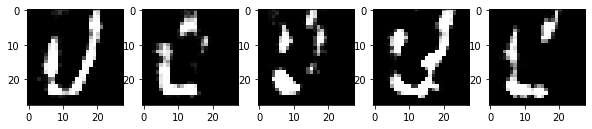

Epochs 10/50, generator loss: 0.736383, discriminator loss: 1.3451746702194214


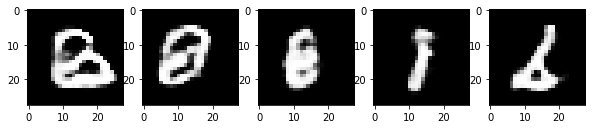

Epochs 20/50, generator loss: 0.771201, discriminator loss: 1.319793939590454


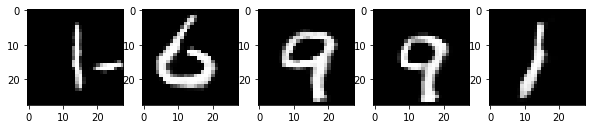

Epochs 30/50, generator loss: 0.809945, discriminator loss: 1.2926108837127686


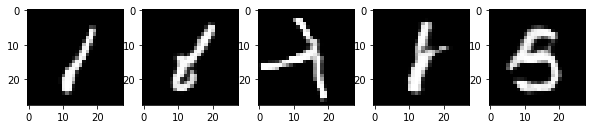

Epochs 40/50, generator loss: 0.851903, discriminator loss: 1.2652757167816162


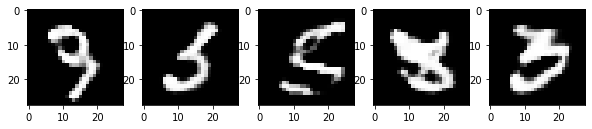

Epochs 50/50, generator loss: 0.896296, discriminator loss: 1.2380479574203491


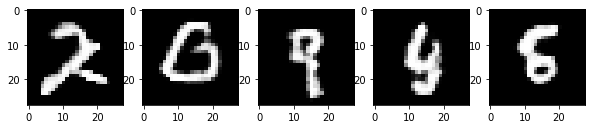

In [11]:
train()